<a href="https://colab.research.google.com/github/mahedishato/DL/blob/main/prediction_picture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/Datasets/picture data/archive (1).zip", "/content/drive/MyDrive/Datasets/picture data")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
from IPython.display import Image

In [3]:
data_csv = pd.read_csv(r'/content/drive/MyDrive/Datasets/picture data/train/train.csv')
print('data shape: ', data_csv.shape)

categories = {0: 'Cargo' , 1: 'Military', 2: 'Carrier', 3: 'Cruise', 4: 'Tankers'}

data_csv['category'] = data_csv['category'] - 1
data_csv['label'] = data_csv['category'].map(categories)
data_csv['label'] = pd.Categorical(data_csv['label'])
data_csv.head()

data shape:  (6252, 2)


,image,category,label
0,2823080.jpg,0,Cargo
1,2870024.jpg,0,Cargo
2,2662125.jpg,1,Military
3,2900420.jpg,2,Carrier
4,2804883.jpg,1,Military


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Counts of observation')

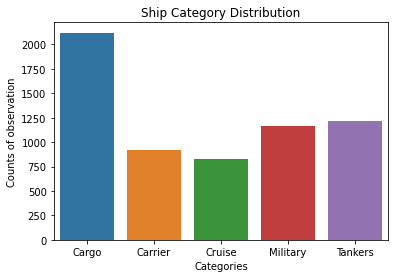

In [4]:
sns.countplot(data_csv['label'])
plt.title('Ship Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Counts of observation')

In [5]:
import cv2

path = r'/content/drive/MyDrive/Datasets/picture data/train/images'

img_list = list(data_csv['image'])

data_img = []

for each in img_list:
    each_path = os.path.join(path,each)
    each_img = cv2.imread(each_path)
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    each_img_resized = cv2.resize(each_img, (128,128))
    data_img.append(each_img_resized)
    
X = np.array(data_img)
print('Shape of X: ', X.shape)

Shape of X:  (6252, 128, 128, 3)


In [6]:
from sklearn.preprocessing import OneHotEncoder

y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(data_csv['category'].values.reshape(-1,1))
print('Shape of y: ', y.shape)

Shape of y:  (6252, 5)


In [7]:
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(X,y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2, random_state=42)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(horizontal_flip= True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5
                              )
validation_gen = ImageDataGenerator(horizontal_flip= True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5
                              )

train_gen.fit(X_train)
validation_gen.fit(X_val)

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

batch_size = 100
epochs = 15

base = Xception(include_top = False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)

head = Dense(5, activation = 'softmax')(x)
model = Model(inputs = base.input, outputs = head)

model.compile(optimizer=Adam(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy']
             )

history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size = batch_size),
                              epochs = epochs,
                              validation_data = validation_gen.flow(X_val, y_val, batch_size = batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size
                             )

83683744/83683744 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
42/42 [==============================] - 49s 757ms/step - loss: 1.3260 - accuracy: 0.4649 - val_loss: 1.7298 - val_accuracy: 0.4262
Epoch 2/15
42/42 [==============================] - 29s 679ms/step - loss: 0.7876 - accuracy: 0.7006 - val_loss: 1.2889 - val_accuracy: 0.5974
Epoch 3/15
42/42 [==============================] - 29s 692ms/step - loss: 0.6106 - accuracy: 0.7629 - val_loss: 0.7051 - val_accuracy: 0.7488
Epoch 4/15
42/42 [==============================] - 29s 684ms/step - loss: 0.5303 - accuracy: 0.8003 - val_loss: 0.6168 - val_accuracy: 0.7667
Epoch 5/15
42/42 [==============================] - 32s 751ms/step - loss: 0.4669 - accuracy: 0.8208 - val_loss: 0.5649 - val_accuracy: 0.7959
Epoch 6/15
42/42 [==============================] - 30s 705ms/step - loss: 0.4250 - accuracy: 0.8386 - val_loss: 0.4934 - val_accuracy: 0.8175
Epoch 7/15
42/42 [==============================] - 29s 704ms/step - loss: 0.4112 - accuracy: 0.8480 - val_loss: 0.4388 - val_accuracy: 0.8335

30/30 [==============================] - 4s 53ms/step


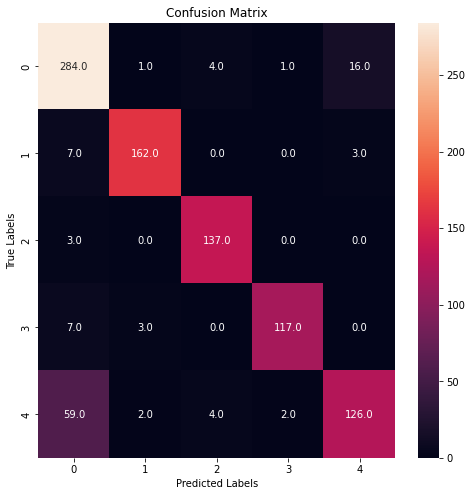

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt = '.1f', ax=ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       306
           1       0.96      0.94      0.95       172
           2       0.94      0.98      0.96       140
           3       0.97      0.92      0.95       127
           4       0.87      0.65      0.75       193

    accuracy                           0.88       938
   macro avg       0.91      0.88      0.89       938
weighted avg       0.89      0.88      0.88       938



In [15]:
model.save("/content/drive/MyDrive/cv/Ship-shape.h5")